In [1]:
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoModel, AutoTokenizer, GPT2Config
import torch
import transformers
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
import datetime
from tqdm import tqdm

/home/tiblias/miniconda3/envs/time-stuff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('datasets/templates/absolute_relative_sentences.csv')
labels = pd.get_dummies(df['specificity'])['absolute']
df_anchored = df[df['specificity'] == 'relative']
df_anchored['sentence'] = df_anchored['sentence'].apply(lambda x: 'Today is the 1st of June, 2021. ' + x)
df_anchored['specificity'] = 'anchored'
df = pd.concat([df, df_anchored])

/tmp/ipykernel_738416/3881520152.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anchored['sentence'] = df_anchored['sentence'].apply(lambda x: 'Today is the 1st of June, 2021. ' + x)
/tmp/ipykernel_738416/3881520152.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anchored['specificity'] = 'anchored'


### Models

In [15]:
config = GPT2Config.from_pretrained("gpt2", output_hidden_states=True)
model = AutoModel.from_pretrained("gpt2", config=config)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

def eval_df(df, model=model, tokenizer=tokenizer):
    model.eval()
    model.to("cuda")
    outputs = []
    for stuff in tqdm(df[['sentence', 'date_idx_end']].values):
        sentence, idx_end = stuff
        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1
        
        hidden_states = model(**input_ids).hidden_states
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,idx_end,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

In [6]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b-it")
model = AutoModel.from_pretrained(
    "google/gemma-2-2b-it",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")


def eval_df(df, model=model, tokenizer=tokenizer):
    model.eval()
    model.to("cuda")
    outputs = []
    for sentence in tqdm(df['sentence']):
        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,-1,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.45s/it]


In [2]:
from transformers import Gemma2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Gemma2Config.from_pretrained("google/gemma-2-2b")
model = AutoModel.from_pretrained(
    "google/gemma-2-2b-it",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")


def eval_df(df, model=model, tokenizer=tokenizer):
    model.eval()
    outputs = []
    for sentence in tqdm(df['sentence']):
        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,-1,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


In [8]:
from transformers import Qwen2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Qwen2Config.from_pretrained("Qwen/Qwen2-0.5B-Instruct")
model = AutoModel.from_pretrained(
    "Qwen/Qwen2-0.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")


def eval_df(df, model=model, tokenizer=tokenizer, idx_column='date_idx_end'):
    model.eval()
    outputs = []
    # for stuff in tqdm(df[['sentence', 'date_idx_end']].values):
    for stuff in tqdm(df[['sentence', idx_column]].values):
        sentence, idx_end = stuff
        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        idx_end = len(tokenizer(sentence[:idx_end])['input_ids']) - 1

        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,idx_end,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

In [12]:
from transformers import Qwen2Config, AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

config = Qwen2Config.from_pretrained("Qwen/Qwen2-0.5B")
model = AutoModel.from_pretrained(
    "Qwen/Qwen2-0.5B",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B")


def eval_df(df, model=model, tokenizer=tokenizer):
    model.eval()
    outputs = []
    for sentence in tqdm(df['sentence']):
        input_ids = tokenizer(sentence, return_tensors="pt").to("cuda")
        hidden_states = model(**input_ids, output_hidden_states=True).hidden_states
        hidden_states = [h.type(torch.float16) for h in hidden_states]
        hidden_states = torch.concat(hidden_states, dim=0).cpu().detach().numpy()[:,-1,:]
        outputs.append(hidden_states)
    return np.stack(outputs, axis=1)

### Activations

In [30]:
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/absolute_ordered_sentences_tagged.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['datetime'] = pd.to_datetime(df['datetime'])
df['label'] = df['datetime'].apply(lambda x: x.timestamp())
# Dates go from 01-01-2019 to 31-12-2019
start = datetime.datetime(2019, 1, 1).timestamp()
end = datetime.datetime(2019, 12, 31).timestamp()
df['label'] = df['label'].apply(lambda x: (x-start)/(end-start))


# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
test_set = df.iloc[int(len(df)*split):]


activations_train_verb = eval_df(train_set, idx_column='verb_idx_end')
activations_test_verb = eval_df(test_set, idx_column='verb_idx_end')
activations_train_date = eval_df(train_set, idx_column='date_idx_end')
activations_test_date = eval_df(test_set, idx_column='date_idx_end')

activations_train = activations_train_date
activations_test = activations_test_date

# all_activations = np.concatenate([activations_train_date, activations_test_date], axis=1)
all_activations = np.concatenate([activations_train_verb, activations_test_verb], axis=1)
all_labels = df['label']

  0%|          | 0/748 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:03<00:00, 51.20it/s]


In [ ]:
transformers.set_seed(42)

df = pd.read_csv('datasets/templates/relative_ordered_sentences.csv')
# Shuffle the dataset
df = df.sample(frac=1)
# Take datetimes and normalize them to a 0-1 range
df['label'] = df['hours_delta']
# Perform absolute value and log scaling
df['label'] = df['label'].apply(lambda x: np.log(np.abs(x)+1))
# Normalize min and max
min_hours = df['label'].min()
max_hours = df['label'].max()
df['label'] = df['label'].apply(lambda x: (x-min_hours)/(max_hours-min_hours))
# Print min and max to check if normalization is correct
print(df['label'].min(), df['label'].max())

df['class'] = df['reference_type']

# Create train and test sets
split = 0.8
train_set = df.iloc[:int(len(df)*split)]
test_set = df.iloc[int(len(df)*split):]

activations_train = eval_df(train_set)
activations_test = eval_df(test_set)

all_activations = np.concatenate([activations_train, activations_test], axis=1)
all_labels = df['label']
all_classes = df['class']

0.0 1.0


100%|██████████| 100/100 [00:01<00:00, 50.30it/s]


In [ ]:
# PLS regression
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_set['label'])
    score = pls.score(activations_test[i], test_set['label'])
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 10 # Override best layer


pls = PLSRegression(n_components=3)
pls.fit(activations_train[best_layer], train_set['label'])

pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 10)
# Get sentences and acivations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=test_set['label'], ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for gemma-2-2b')
plt.show()

Layer 7 score: 0.6922317525441698
Layer 8 score: 0.6291506383536228
Layer 9 score: 0.5745249214094762
Layer 10 score: 0.5916112553678988
Layer 11 score: 0.5560977768748959
Layer 12 score: -0.5294642036381976
Layer 13 score: -0.281744368282202
Layer 14 score: -0.02379117512842287
Layer 15 score: 0.03498902817518393
Layer 16 score: 0.24250972826346812
Layer 17 score: -0.0965008025268213
Layer 18 score: 0.07649361548591395
Best layer: 7, score: 0.6922317525441698


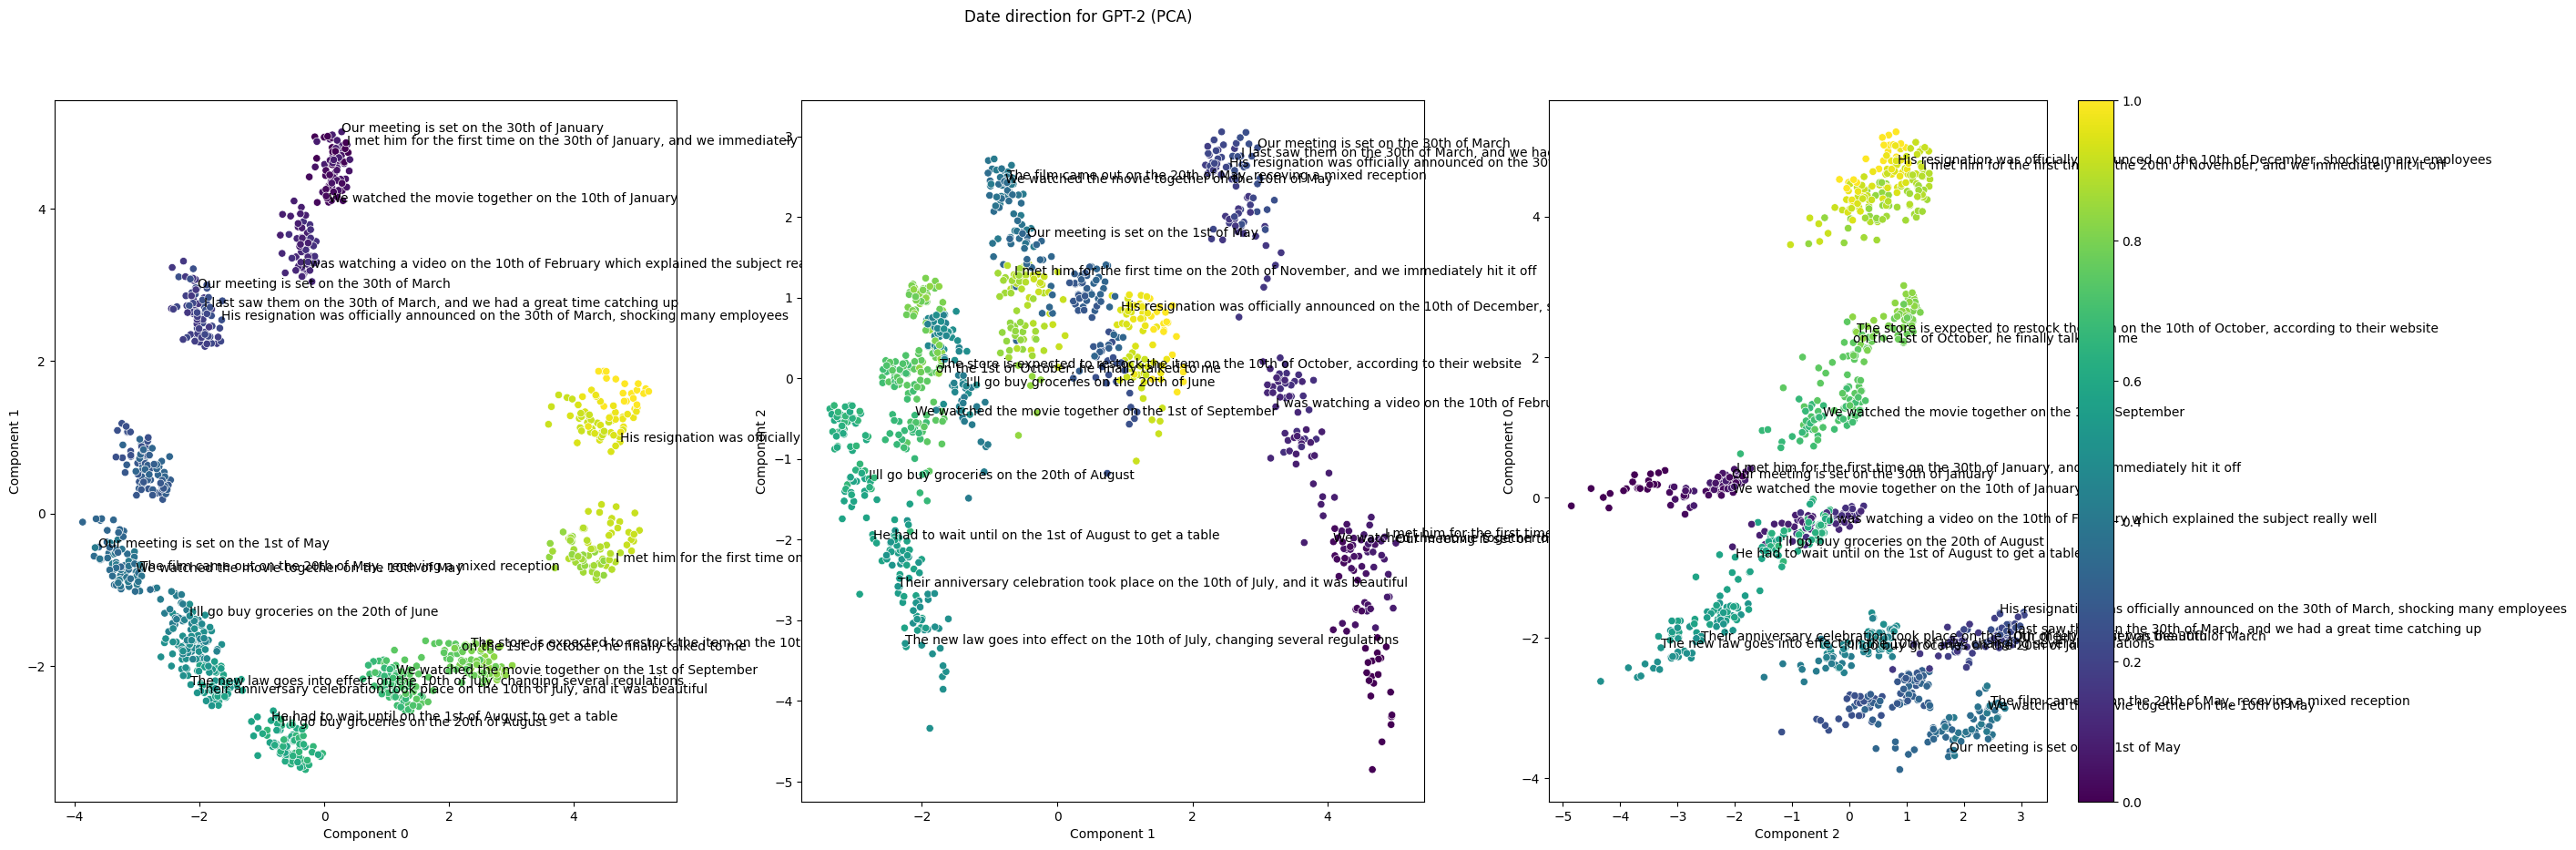

In [12]:
# PCA with a continuous label

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_test = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_test[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 6 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_train = pca.transform(activations_train[best_layer])
pca_test = pca.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_train[:, i % 3], y=pca_train[:, (i + 1) % 3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pca_test[:, i % 3], y=pca_test[:, (i + 1) % 3], hue=test_set['label'], ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PCA with discrete classes

best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_test = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_test[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 6 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
classes = df['class'].unique()
palette = {classes[i]: sns.color_palette()[i] for i in range(len(classes))}
print(palette)
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_classes, ax=ax, palette=palette)
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')

# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

Layer 7 score: 0.6922317561827149
Layer 8 score: 0.6291505956696459
Layer 9 score: 0.5745248371202459
Layer 10 score: 0.5916112428585731
Layer 11 score: 0.5560982710582432
Layer 12 score: -0.5294636803128726
Layer 13 score: -0.28174512581134004
Layer 14 score: -0.02379071712605361
Layer 15 score: 0.034988615645642644
Layer 16 score: 0.24250899734220657
Layer 17 score: -0.09650080174609732
Layer 18 score: 0.07649336427182105
Best layer: 7, score: 0.6922317561827149


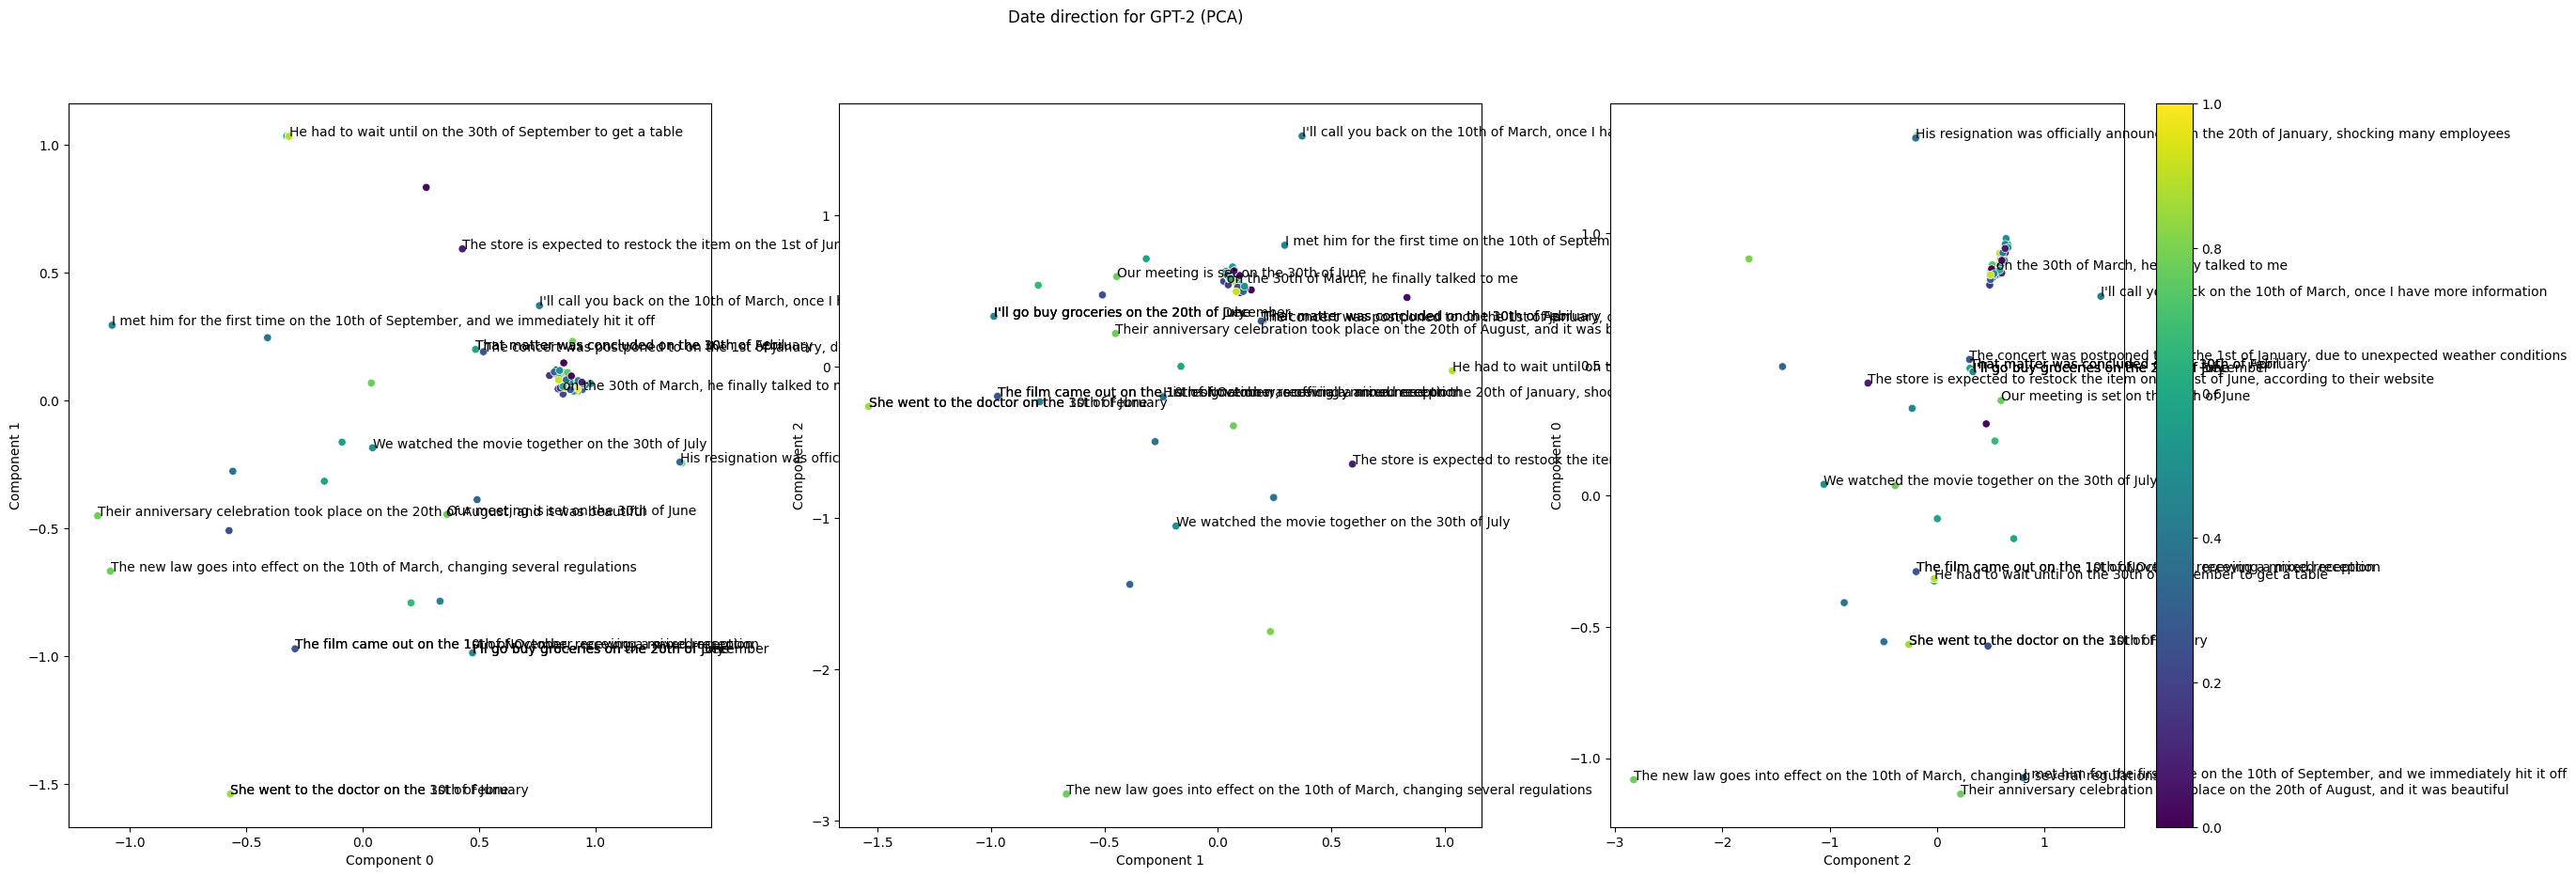

In [35]:
# PCA with a continuous label and evaluation on verbs
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i / len(activations_train) < 0.25 or i / len(activations_train) > 0.75:
        continue
    pca = PCA(n_components=2)
    pca.fit(layer)
    transformed_train = pca.transform(layer)
    transformed_test = pca.transform(activations_test[i])
    score = np.corrcoef(transformed_test[:, 0], test_set['label'])[0, 1]  # Correlation as a proxy for score
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

# best_layer = 18 # Override best layer

pca = PCA(n_components=3)
pca.fit(activations_train[best_layer])
pca_all = pca.transform(all_activations[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 20)
# Get sentences and activations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pca.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pca_all[:, i % 3], y=pca_all[:, (i + 1) % 3], hue=all_labels, ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i % 3], rnd_activations[j, (i + 1) % 3]))
    ax.set_xlabel(f'Component {i % 3}')
    ax.set_ylabel(f'Component {(i + 1) % 3}')
    ax.get_legend().set_visible(False)

fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for GPT-2 (PCA)')
plt.show()

In [ ]:
# PLS regression with two classes
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    if i/len(activations_train) < 0.25 or i/len(activations_train) > 0.75:
        continue
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_set['label'])
    score = pls.score(activations_test[i], test_set['label'])
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 10 # Override best layer


pls = PLSRegression(n_components=3)
pls.fit(activations_train[best_layer], train_set['label'])

pls_train = pls.transform(activations_train[best_layer])
pls_test = pls.transform(activations_test[best_layer])

# Generate 10 indices
indices = np.random.choice(len(all_activations[best_layer]), 10)
# Get sentences and acivations
rnd_sent = df['sentence'].iloc[indices]
rnd_activations = all_activations[best_layer][indices]
# Transform activations
rnd_activations = pls.transform(rnd_activations)

# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
for i, ax in enumerate(axs):
    sns.scatterplot(x=pls_train[:, i%3], y=pls_train[:, (i+1)%3], hue=train_set['label'], ax=ax, palette='viridis')
    sns.scatterplot(x=pls_test[:, i%3], y=pls_test[:, (i+1)%3], hue=test_set['label'], ax=ax, palette='viridis')
    for j, txt in enumerate(rnd_sent):
        ax.annotate(txt, (rnd_activations[j, i%3], rnd_activations[j, (i+1)%3]))
    ax.set_xlabel(f'Component {i%3}')
    ax.set_ylabel(f'Component {(i+1)%3}')
    ax.get_legend().set_visible(False)


fig.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=axs[2])
# Set title
plt.suptitle('Date direction for gemma-2-2b')
plt.show()

### Extra stuff

In [7]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = eval_df(train_set)
activations_test = eval_df(test_set)
activations_anch = eval_df(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

ss = StandardScaler()
ss.fit(activations_train)

best_layer = 6 # Override best layer


pca = PCA(n_components=3)

pca.fit(ss.transform(activations_train[best_layer]))

pls_all = pca.transform(ss.transform(all_activations[best_layer]))
# plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
# sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)
# Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels, ax=axs[0])
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 2], hue=all_labels, ax=axs[1])
sns.scatterplot(x=pls_all[:, 1], y=pls_all[:, 2], hue=all_labels, ax=axs[2])
plt.show()

# pca = PCA(n_components=3)
# pca.fit(layer4_outputs)
# pca_output = pca.transform(layer4_outputs)
# # Plot results in three subplots. First for components 1 and 2, second for 1 and 3, third for 2 and 3
# fig, axs = plt.subplots(1, 3, figsize=(30, 10))
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 1], hue=labels, palette='viridis', ax=axs[0])
# sns.scatterplot(x=pca_output[:, 0], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[1])
# sns.scatterplot(x=pca_output[:, 1], y=pca_output[:, 2], hue=labels, palette='viridis', ax=axs[2])
# plt.show()

KeyError: 'specificity'

In [6]:
transformers.set_seed(11)

abs_rel_set = df[df['specificity'] != 'anchored']
anch_set = df[df['specificity'] == 'anchored']
# Create train and test sets
train_set = abs_rel_set.sample(frac=0.8)
test_set = abs_rel_set.drop(train_set.index)
train_labels = pd.get_dummies(train_set['specificity'])['absolute']
test_labels = pd.get_dummies(test_set['specificity'])['absolute']

print(train_set.iloc[0])

activations_train = eval_df(train_set)
activations_test = eval_df(test_set)
activations_anch = eval_df(anch_set)

all_activations = np.concatenate([activations_train, activations_test, activations_anch], axis=1)
all_labels = df['specificity']

print(activations_train[0,0,:5])

print(activations_train.shape)
best_score = 0
best_layer = 0
for i, layer in enumerate(activations_train):
    pls = PLSRegression(n_components=2)
    pls.fit(layer, train_labels)
    score = pls.score(activations_test[i], test_labels)
    print(f'Layer {i} score: {score}')
    if score > best_score:
        best_score = score
        best_layer = i
print(f'Best layer: {best_layer}, score: {best_score}')

best_layer = 6 # Override best layer


pls = PLSRegression(n_components=2)
pls.fit(activations_train[best_layer], train_labels)

pls_all = pls.transform(all_activations[best_layer])
plt.figure(figsize=(8, 8))
# sns.scatterplot(x=pls_output[:, 0], y=pls_output[:, 1], hue=df['specificity'], palette='viridis')
sns.scatterplot(x=pls_all[:, 0], y=pls_all[:, 1], hue=all_labels)

plt.title('Latent space directions found by PLS')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

KeyError: 'specificity'